In [2]:
import zipfile
import os
from os import walk
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup
%matplotlib inline

In [1]:
from google.colab import files
uploaded = files.upload()


Saving SpamData.zip to SpamData.zip


In [3]:
zip_file = 'SpamData.zip'
unzip_dir = '/content/DataExtracted'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)


In [ ]:
import os
current_directory = os.getcwd()
print("Current working directory:", current_directory)

**Constants**

In [106]:
EXAMPLE_FILE = 'DataExtracted/SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'DataExtracted/SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'DataExtracted/SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'DataExtracted/SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'DataExtracted/SpamData/02_Training/test-data.txt'




In [5]:
stream = open(EXAMPLE_FILE, encoding='utf-8')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [6]:
stream = open(EXAMPLE_FILE, encoding='utf-8')
is_body = False
lines = []

for line in stream:
  if is_body:
    lines.append(line)
  elif line == '\n':
    is_body = True

stream.close()
email_body = '\n'.join(lines)

print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

**Generator Functions**

In [ ]:
def generate_squares(N):
  for my_number in range(N):
    yield my_number ** 2

In [ ]:
for i in generate_squares(5):
  print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

**Email body extraction**

In [7]:
def email_body_generator(path):

  for root, dirnames, filenames in walk(path):
    for file_name in filenames:

      filepath = join(root, file_name)
      stream = open(filepath, encoding='latin-1')
      is_body = False
      lines = []

      for line in stream:
        if is_body:
          lines.append(line)
        elif line == '\n':
          is_body = True

      stream.close()
      email_body = '\n'.join(lines)

      yield file_name, email_body

In [8]:
def df_from_directory(path,classification):
  rows = []
  row_names = []

  for file_name, email_body in email_body_generator(path):
    rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
    row_names.append(file_name)


  return pd.DataFrame(rows, index=row_names)

In [9]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = pd.concat([spam_emails, df_from_directory(SPAM_2_PATH, 1)])
spam_emails.head()

,MESSAGE,CATEGORY
00199.9be6cec49c53210152780926cdeb59ff,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1
00194.767c323b4ae7a4909397e42cbd0c56a4,------=_NextPart_000_006C_6B8D6A65.3C3C56F\n\n...,1
00208.369921416af87a0b70f133632131b184,--0-1118764524-1030968705=:44128\n\nContent-Ty...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1
00091.bcaf9648660ba372bc4d542aa06456ad,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1


In [10]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, 0)
ham_emails = pd.concat([ham_emails, df_from_directory(EASY_NONSPAM_2_PATH, 0)])
ham_emails.shape

(3901, 2)

In [11]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire DataFrame is:', data.shape)
data.head()

Shape of entire DataFrame is: (5799, 2)


,MESSAGE,CATEGORY
00199.9be6cec49c53210152780926cdeb59ff,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1
00194.767c323b4ae7a4909397e42cbd0c56a4,------=_NextPart_000_006C_6B8D6A65.3C3C56F\n\n...,1
00208.369921416af87a0b70f133632131b184,--0-1118764524-1030968705=:44128\n\nContent-Ty...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1
00091.bcaf9648660ba372bc4d542aa06456ad,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1


In [ ]:
data.tail()

,MESSAGE,CATEGORY
00911.91dd363a1ba091de446dd40a24816ab3,"On Fri, 26 Jul 2002, Ian Andrew Bell wrote:\n\...",0
01090.9c92673e26cabc5a37ac3e2b1b2bf8df,\n\n\n\nJohn Hall\n\n13464 95th Ave NE\n\nKirk...,0
00664.28f4cb9fad800d0c7175d3a67e6c6458,"Key concepts: Tokyo, urban overheating,\n\ncl...",0
00715.c11e77af45a2debe41aed46b2be09d59,\n\nMusic school jokes --\n\n\n\nAmerican cond...,0
00492.bc9e8dcbe986afe7ed1f38e988f43c8b,"As list administrator, your authorization is r...",0


**Data Cleaning: Checking for missing values**

In [12]:
#Check if any message bodies are null
#data.MESSAGE
#second option
data['MESSAGE'].isnull().values.any()


False

In [13]:
#check if there are empty emails(string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [14]:
(data.MESSAGE.str.len() == 0).sum()

3

In [15]:
data.MESSAGE.isnull().sum()

0

**Locate empty emails**

In [16]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [17]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [18]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

**Remove System File Entries from Dataframe**

In [19]:
data.drop(['cmds'], inplace=True)


In [20]:
data.shape

(5796, 2)

**Add Document Ids to track emails in dataset**

In [21]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids


In [ ]:
data.DOC_ID

,DOC_ID
00416.bff1badad869f205fdb54f311f060734,0
00023.b6d27c684f5fc803cfa1060adb2d0805,1
00038.8d93819b95ff90bf2e2b141c2909bfc9,2
00331.a61788d316e7393c8bbf8ee19b24c713,3
00226.e0e2704cde3bbd561a98042f4a3baf5f,4
...,...
00855.25cdd1d4b3805757439866eb261643f6,5791
01394.b4dd1cece01b908f040e33493643c4a4,5792
01234.538d99529a2f797af84e2aadebce58b7,5793
00816.953e88a20d4acc17467a8ee832481093,5794


In [22]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1,00199.9be6cec49c53210152780926cdeb59ff
1,------=_NextPart_000_006C_6B8D6A65.3C3C56F\n\n...,1,00194.767c323b4ae7a4909397e42cbd0c56a4
2,--0-1118764524-1030968705=:44128\n\nContent-Ty...,1,00208.369921416af87a0b70f133632131b184
3,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
4,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00091.bcaf9648660ba372bc4d542aa06456ad


In [23]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,"Um, you've confused RealAudio and RealNames. B...",0,00750.4e6d7b346042e39f416017bb3292bd08
5792,Quoting Ciaran Johnston (cj@nologic.org):\n\n\...,0,00438.a4e08ec27cc4d6d5dd27d43178d3bc17
5793,\n\n> I'm sure if you call their customer serv...,0,00765.faf588d84afc2fef853ab73a5b797cce
5794,Elias Sinderson <elias@cse.ucsc.edu> writes:\n...,0,00863.d9ae47fc90d47d17f9765634e5950c37
5795,"On Sat, Jul 20, 2002 at 12:06:35PM +0100, Greg...",0,00038.fba603f864720b7894b7b05e6e3f93c0


**Save to file using Pandas**

In [24]:
data.to_json(DATA_JSON_FILE)

**Number of spam messages visualised**

In [25]:
data.CATEGORY.value_counts()

,count
CATEGORY,
0,3900
1,1896


In [26]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]
print('Amount of spam messages:', amount_of_spam)
print('Amount of ham messages:', amount_of_ham)

Amount of spam messages: 1896
Amount of ham messages: 3900


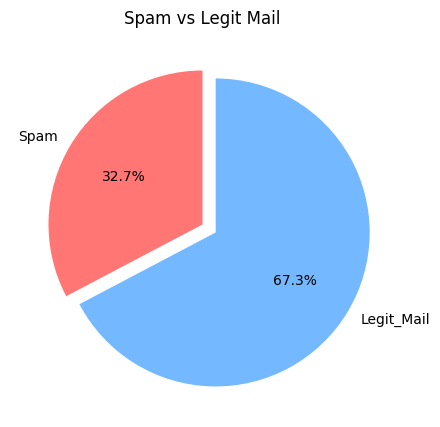

In [27]:
category_names = ['Spam', 'Legit_Mail']
sizes = [amount_of_spam, amount_of_ham]

custom_colors = ['#ff7675','#74b9ff']
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':10},
        startangle=90, autopct='%1.1f%%', colors = custom_colors, explode=[0, 0.1])
plt.title('Spam vs Legit Mail')
plt.show()

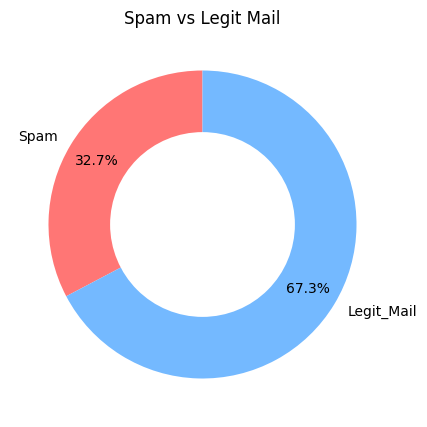

In [ ]:
category_names = ['Spam', 'Legit_Mail']
sizes = [amount_of_spam, amount_of_ham]

custom_colors = ['#ff7675','#74b9ff']
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':10},
        startangle=90, autopct='%1.1f%%', colors = custom_colors, pctdistance=0.8)

#draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Spam vs Legit Mail')
plt.show()

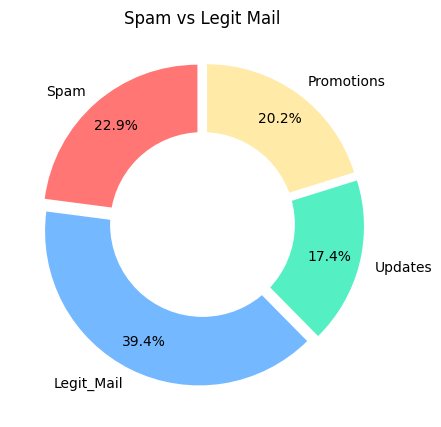

In [ ]:
category_names = ['Spam', 'Legit_Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
offset = [0.05, 0.05, 0.05, 0.05]

custom_colors = ['#ff7675','#74b9ff', '#55efc4', '#ffeaa7']
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':10},
        startangle=90, autopct='%1.1f%%', colors = custom_colors, pctdistance=0.8, explode=offset)

#draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Spam vs Legit Mail')
plt.show()

# **Natural Language Processing**
**Text Pre-Processing**

In [28]:
msg = 'All work and no play makes Jack a dull boy'
msg.lower()

'all work and no play makes jack a dull boy'

**Download the NLTK Resources(Tokenizer & Stopwords)**

In [29]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Tokenising**

In [31]:
msg = 'All work and no play makes Jack a dull boy'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

**Removing stop words**

In [32]:
stop_words = set(stopwords.words('english'))

In [33]:
if 'this' in stop_words:
  print('True')
else:
  print('Nope.Not in here')

True


In [34]:
msg = 'All work and no play makes Jack a dull boy.To be or not to be that is the question.'
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
  if word not in stop_words:
    filtered_words.append(word)

print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'boy.to', 'question', '.']


**Word Stems and Stemming**

In [35]:
msg = 'All work and no play makes Jack a dull boy.To be or not to be that is the question. \
Nobody expects Spanish Inquisition'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []

for word in words:
  if word not in stop_words:
    stemmed_word = stemmer.stem(word)
    filtered_words.append(word)

print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'boy.to', 'question', '.', 'nobody', 'expects', 'spanish', 'inquisition']


In [36]:
msg = 'All work and no play makes Jack a dull boy.To be or not to be that is the question.??? \
Nobody expects Spanish Inquisition'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')
filtered_words = []

for word in words:
  if word not in stop_words and word.isalpha():
    stemmed_word = stemmer.stem(word)
    filtered_words.append(word)

print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'nobody', 'expects', 'spanish', 'inquisition']


**Removing HTML tags from emails**

In [37]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

--0-1118764524-1030968705=:44128

Content-Type: text/plain; charset=iso-8859-1

Content-Transfer-Encoding: 8bit





KEVIN GEORGE



ABIDJAN,COTE D'IVORIE

WEST AFRICA



Dearest one,



Although we have not met, I got your contact through the internet and  decided to contact you for assistance. I was, until recently, a final  year engineering student of the University of Sierra Leone,West Africa.  Early in January last year, the rebels

in my country struck our township and killed my parents in one of their attacks. My late father, King Christopher George being the King of the Town was a prime target.



Fortunately for me, I was in school when the attack took  place. I equally lost my only sister to the rebels. When I got home for the remains of my parents and the subsequent burial that followed, I discovered a document indicating that my late father had deposited some $6M.United States Dollars(six million united states dollars) with one of the private security company here in abidja

In [38]:
soup.get_text()

"--0-1118764524-1030968705=:44128\n\nContent-Type: text/plain; charset=iso-8859-1\n\nContent-Transfer-Encoding: 8bit\n\n\n\n\n\nKEVIN GEORGE\n\n\n\nABIDJAN,COTE D'IVORIE\n\nWEST AFRICA\n\n\n\nDearest one,\n\n\n\nAlthough we have not met, I got your contact through the internet and  decided to contact you for assistance. I was, until recently, a final  year engineering student of the University of Sierra Leone,West Africa.  Early in January last year, the rebels\n\nin my country struck our township and killed my parents in one of their attacks. My late father, King Christopher George being the King of the Town was a prime target.\n\n\n\nFortunately for me, I was in school when the attack took  place. I equally lost my only sister to the rebels. When I got home for the remains of my parents and the subsequent burial that followed, I discovered a document indicating that my late father had deposited some $6M.United States Dollars(six million united states dollars) with one of the private 

**Fuctions for email processing**

In [47]:
def clean_message(message, stemmer=PorterStemmer(),
                  stop_words = set(stopwords.words('english'))):

   words = word_tokenize(message.lower())
   filtered_words = []

   for word in words:
    if word not in stop_words and word.isalpha():
      stemmed_word = stemmer.stem(word)
      filtered_words.append(stemmer.stem(word))


   return filtered_words


In [40]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [46]:
def clean_msg_no_html(message, stemmer=PorterStemmer(),
                 stop_words=set(stopwords.words('english'))):

    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()

    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())

    filtered_words = []

    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#             filtered_words.append(word)

    return filtered_words

In [50]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['kevin',
 'georg',
 'abidjan',
 'cote',
 'west',
 'africa',
 'dearest',
 'one',
 'although',
 'met',
 'got',
 'contact',
 'internet',
 'decid',
 'contact',
 'assist',
 'recent',
 'final',
 'year',
 'engin',
 'student',
 'univers',
 'sierra',
 'leon',
 'west',
 'africa',
 'earli',
 'januari',
 'last',
 'year',
 'rebel',
 'countri',
 'struck',
 'township',
 'kill',
 'parent',
 'one',
 'attack',
 'late',
 'father',
 'king',
 'christoph',
 'georg',
 'king',
 'town',
 'prime',
 'target',
 'fortun',
 'school',
 'attack',
 'took',
 'place',
 'equal',
 'lost',
 'sister',
 'rebel',
 'got',
 'home',
 'remain',
 'parent',
 'subsequ',
 'burial',
 'follow',
 'discov',
 'document',
 'indic',
 'late',
 'father',
 'deposit',
 'state',
 'dollar',
 'six',
 'million',
 'unit',
 'state',
 'dollar',
 'one',
 'privat',
 'secur',
 'compani',
 'abidjan',
 'cote',
 'money',
 'accord',
 'docement',
 'meant',
 'build',
 'auto',
 'repair',
 'compani',
 'late',
 'father',
 'complet',
 'studi',
 'upon',
 'discover

# **Apply Cleaning and Tokenisation to all messages**

In [51]:
data.iat[2, 2]

'00208.369921416af87a0b70f133632131b184'

In [52]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,=3C!DOCTYPE HTML PUBLIC =22-=2F=2FW3C=2F=2FDTD...,1,00407.7a447442b07fa08de0b69e907ce3ca53
6,"<HTML>\n\n<BODY>\n\n<iframe align=""center"" mar...",1,00329.af4af411fb1268d1461b29fa2d2145a3
7,This is a multi-part message in MIME format.\n...,1,00352.19a8ba03f566612e0b9e124609d9dbd0
8,<html>\n\n<head>\n\n<title>Untitled Document</...,1,00107.e6cd2d9f49514710dc85db0fef5b8726
9,<html>\n\n<head>\n\n<title></title>\n\n</head>...,1,00176.79f82496c612ea28f45f13ca5c47f8c2
10,--374035298.1030784379296.JavaMail.SYSTEM.emas...,1,00191.9ff80a41f015b7a6c409732e41c0df07


In [53]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [54]:
flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

767

In [55]:
flat_list

['html',
 'head',
 'meta',
 'meta',
 'gener',
 'microsoft',
 'frontpag',
 'meta',
 'progid',
 'meta',
 'titl',
 'norton',
 'ad',
 'bodi',
 'tabl',
 'ffffff',
 'tr',
 'td',
 'ffffff',
 'center',
 'font',
 'impact',
 'take',
 'control',
 'comput',
 'softwar',
 'tabl',
 'ffffff',
 'e',
 'tr',
 'td',
 'ffffff',
 'tabl',
 'ffffff',
 'tr',
 'td',
 'center',
 'b',
 'font',
 'tahoma',
 'norton',
 'systemwork',
 'font',
 'tahoma',
 'softwar',
 'suit',
 'font',
 'time',
 'ew',
 'roman',
 'br',
 'profession',
 'edit',
 'tabl',
 'tr',
 'td',
 'center',
 'b',
 'font',
 'tahoma',
 'ffffff',
 'includ',
 'six',
 'font',
 'tahoma',
 'ye',
 'font',
 'tahoma',
 'ffffff',
 'util',
 'br',
 'font',
 'oma',
 'font',
 'tahoma',
 'ffffff',
 'special',
 'font',
 'tahoma',
 'low',
 'font',
 'tahoma',
 'ffffff',
 'price',
 'font',
 'tahoma',
 'tabl',
 'ffffff',
 'tr',
 'td',
 'b',
 'font',
 'tahoma',
 'font',
 'softwar',
 'font',
 'ffffff',
 'br',
 'nbsp',
 'font',
 'protect',
 'comput',
 'unwant',
 'hazard',
 'u

In [56]:
nested_list = data.MESSAGE.apply(clean_msg_no_html)

<ipython-input-46-dfeff0958df2>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
<ipython-input-46-dfeff0958df2>:5: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


In [57]:
nested_list.tail()

,MESSAGE
DOC_ID,
5791,"[um, confus, realaudio, realnam, bad, bit, lui..."
5792,"[quot, ciaran, johnston, cj, thank, repli, see..."
5793,"[sure, call, custom, servic, number, unsubscri..."
5794,"[elia, sinderson, write, sorri, karl, confus, ..."
5795,"[sat, jul, greg, farrel, wrote, old, laptop, w..."


**Using Logic to Slice Dataframes**

In [58]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [59]:
data[data.CATEGORY == 1].tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
1891,>From the ethnobotanical herbalists who brough...,1,00472.3c51cf86307bc98c54d856887a81e9ac
1892,\n\n<HTML>\n\n<BODY>\n\n<!DOCTYPE HTML PUBLIC ...,1,00072.eb147f0714c89bf35a0ab1852890555d
1893,------=_NextPart_000_00E4_86E61E0A.B5488E11\n\...,1,00430.d3915a3e7a9cbd8f9a7e6221eb40253d
1894,"Dear dhudobenko ,\n\n\n\n<html>\n\n<body>\n\n<...",1,00872.f50d5fd1a37e535e0a0adb223ef40f36
1895,=================================\n\n\n\nGuara...,1,01114.1499922e828350a4f6076ef4a0de3ec5


In [60]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [61]:
doc_ids_ham

Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
       ...
       5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
      dtype='int64', name='DOC_ID', length=3900)

**Subsetting a Series with an Index**

In [62]:
type(doc_ids_ham)

pandas.core.indexes.base.Index

In [63]:
type(nested_list)

pandas.core.series.Series

In [64]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [65]:
nested_list_ham.shape

(3900,)

In [66]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [67]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

20815

In [68]:
normal_words[:10]

,count
http,7563
use,3633
list,2880
one,2373
get,2286
mail,2255
would,2003
like,1931
messag,1849
work,1800


In [69]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in the spam messages

13242

In [70]:
spammy_words[:10]

,count
http,3097
email,3090
free,2585
click,2058
receiv,1989
list,1971
get,1914
pleas,1852
busi,1792
order,1746


# Generate Vocabulary & Dictionary

In [71]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

<ipython-input-46-dfeff0958df2>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
<ipython-input-46-dfeff0958df2>:5: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


In [72]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27334


,count
http,10660
use,5019
list,4851
email,4367
get,4200


In [73]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
Name: count, dtype: int64


**Create Vocabulary DataFrame with a WORD_ID**

In [75]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


**Save the Vocabulary as a CSV File**

In [76]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

**Checking if a Word is Part of the Vocabulary**

In [77]:
any(vocab.VOCAB_WORD == 'machine') # inefficient

False

In [78]:
'brew' in set(vocab.VOCAB_WORD) # better way

False

**Find the Email with the Most Number of Words**

In [79]:
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [80]:
# Python List Comprehension
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lengths))

Nr words in the longest email: 7671


In [81]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))

Email position in the list (and the data dataframe) 5183


In [82]:
stemmed_nested_list[np.argmax(clean_email_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [83]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

**Creating a DataFrame with one Word per Column**

In [84]:
type(stemmed_nested_list)

pandas.core.series.Series

In [85]:
type(stemmed_nested_list.tolist())

list

In [86]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,norton,ad,take,control,comput,softwar,norton,systemwork,softwar,suit,...,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,kevin,georg,abidjan,cote,west,africa,dearest,one,although,met,...,None,None,None,None,None,None,None,None,None,None
3,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None
4,copyright,right,reservedif,would,longer,like,us,contact,feel,havereceiv,...,None,None,None,None,None,None,None,None,None,None


In [87]:
word_columns_df.shape

(5796, 7671)

**Splitting the Data into a Training and Testing Dataset**

In [88]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                   test_size=0.3, random_state=42)

In [89]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4057
Fraction of training set 0.6999654934437544


In [ ]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

In [90]:
y_train.head()

,CATEGORY
DOC_ID,
4844,0
4727,0
5022,0
3504,0
3921,0


**Create a Sparse Matrix for the Training Data**

In [91]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [92]:
word_index.get_loc('thu')

392

In [93]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.

    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """

    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []

    for i in range(nr_rows):
        for j in range(nr_cols):

            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]

                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}

                dict_list.append(item)

    return pd.DataFrame(dict_list)

In [94]:
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

In [95]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,879
1,0,4844,1,878
2,0,4844,1,979
3,0,4844,1,1359
4,0,4844,1,2208


In [96]:
sparse_train_df.shape

(442180, 4)

In [97]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
442175,1,860,1,18
442176,1,860,1,28
442177,1,860,1,1511
442178,1,860,1,231
442179,1,860,1,0


**Combine Occurrences with the Pandas groupby() Method**

In [98]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      1       1              1
       2       1              3
       3       1              3
       4       1              1
       7       1              2

In [99]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [100]:
data.MESSAGE[0]

'<html>\n\n\n\n<head>\n\n<meta http-equiv=3D"Content-Language" content=3D"en-us">\n\n<meta name=3D"GENERATOR" content=3D"Microsoft FrontPage 4.0">\n\n<meta name=3D"ProgId" content=3D"FrontPage.Editor.Document">\n\n<meta http-equiv=3D"Content-Type" content=3D"text/html; charset=3Dwindows-=\n\n1252">\n\n<title>Norton AD</title>\n\n</head>\n\n\n\n<body>\n\n\n\n<table border=3D"0" width=3D"489" height=3D"54" bgcolor=3D"#FFFFFF">\n\n  <tr>\n\n    <td width=3D"100%" height=3D"48" bgcolor=3D"#FFFFFF" align=3D"center">=\n\n<font face=3D"Impact" color=3D"#CC0000" size=3D"3">Take\n\n      Control of Your Computer With This Top-of-the-Line Software!</font><=\n\n/td>\n\n  </tr>\n\n</table>\n\n\n\n<table border=3D"5" cellspacing=3D"3" width=3D"489" cellpadding=3D"3" bgco=\n\nlor=3D"#990033"  bordercolor=3D"#FFFFFF" style=3D"border-collapse: collaps=\n\ne" bordercolordark=3D"#000000" height=3D"567" bordercolorlight=3D"#FFFF99"=\n\n>\n\n  <tr>\n\n    <td width=3D"467" height=3D"555" bordercolorlight=

In [101]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,1,1,1
1,0,2,1,3
2,0,3,1,3
3,0,4,1,1
4,0,7,1,2


In [102]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
261588,5795,1829,0,1
261589,5795,2208,0,2
261590,5795,2277,0,1
261591,5795,2408,0,1
261592,5795,2446,0,2


In [103]:
vocab.at[1923, 'VOCAB_WORD']

'md'

In [104]:
data.MESSAGE[5795]

"On Sat, Jul 20, 2002 at 12:06:35PM +0100, Greg Farrel wrote:\n\n> \n\n> > An old laptop would probably be ideal.  That way, it comes with its own \n\n> > UPS (the battery).\n\n> D'oh. I ment to say that I cant use a laptop, as I have a pci wireless\n\n> card and the cable for it (about 180 dollars). So it has to be a pc, with\n\n> a pci 2.2 connector (ie some pentiums, and anything above)\n\n> \n\n>  > \n\n> > Some people strip down old 486 boxes, take out the hard drive, disable\n\n> > the fans, and run the thing from just a floppy drive or a CDR you've\n\n> > burned for the purpose.  \n\n> I'd do that with my 166, but the psu has a fan. And a 486 wont support my\n\n> wireless card :( I know. I'm awkward,\n\n\n\nTry www.quietpc.com.  Don't know if they have fanless PSUs but they claim\n\nto have really, really quiet ones.\n\n\n\nLater,\n\nKenn\n\n\n\n\n\n-- \n\nIrish Linux Users' Group Social Events: social@linux.ie\n\nhttp://www.linux.ie/mailman/listinfo/social for (un)subscription 

In [105]:
train_grouped.shape

(261593, 4)

In [121]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
4675,sun,jul,kevin,lyda,mention,tutori,thank,donnacha,sinc,apach,...,None,None,None,None,None,None,None,None,None,None
4220,guido,perhap,use,would,tim,could,check,pickl,gener,one,...,None,None,None,None,None,None,None,None,None,None
2484,hi,leav,even,next,monday,access,whatsoev,singl,comput,woohoo,...,None,None,None,None,None,None,None,None,None,None
2418,tue,sep,bst,jame,gibbon,wrote,tom,reingold,wrote,threat,...,None,None,None,None,None,None,None,None,None,None
5110,fri,paul,linehan,wrote,look,disk,suse,anybodi,reason,price,...,None,None,None,None,None,None,None,None,None,None


In [122]:
y_test.head()

,CATEGORY
DOC_ID,
4675,0
4220,0
2484,0
2418,0
5110,0


In [123]:
X_test.shape

(1739, 7671)

In [124]:
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

In [125]:
sparse_test_df.shape

(190427, 4)

In [126]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,21,1,2
1,8,26,1,1
2,8,425,1,1
3,8,476,1,1
4,8,1401,1,1


In [127]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

**Save Training Data as .txt File**

In [128]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [129]:
test_grouped.shape

(114549, 4)

In [108]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

**Pre-Processing Subtleties**

In [130]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [131]:
len(test_doc_ids)

1722

In [112]:
len(X_test)

1739

In [132]:
set(X_test.index.values) - test_doc_ids # Excluded emails after pre-processing

{70,
 95,
 156,
 195,
 286,
 346,
 411,
 414,
 426,
 443,
 447,
 534,
 829,
 837,
 1121,
 1209,
 1893}

In [114]:
data.MESSAGE[14]

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1034F3_01C259AF.CA052980\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: 7bit\n\n\n\n Welcome to Jefferson Pilot\'s\n\n Gateway to Wealth\n\n As one of the industry\'s premier producers, you must continually seek\n\nqualified cutting edge services.\n\n Financial Profiles\t\n\n Concept\tProfiles+ Professional is a personal and business\n\nanalysis tool that analyzes a client\'s insurance, investment and\n\nfinancial planning goals, to help them see their situation today\n\ncompared to their objectives. \t\n\n Market\tProfiles+ Professional is an ideal tool for true financial\n\nplanning. It not only provides a thorough analysis, including asset\n\nallocation, but it can calculate tax implications in a client\'s plan.\n\nDue to its modular format, it can be used for specific planning needs,\n\nas well as more comprehensive planning. \t\n\n Benefits\n\nThis software not only pr

In [115]:
data.loc[14]

,14
MESSAGE,This is a multi-part message in MIME format.\n...
CATEGORY,1
FILE_NAME,00283.e8e42ee52f919afd2a453983f1256b1d


In [116]:
clean_msg_no_html(data.at[14, 'MESSAGE'])

['messag',
 'mime',
 'format',
 'welcom',
 'jefferson',
 'gateway',
 'wealth',
 'one',
 'industri',
 'premier',
 'produc',
 'must',
 'continu',
 'seek',
 'qualifi',
 'cut',
 'edg',
 'servic',
 'financi',
 'profil',
 'concept',
 'profession',
 'person',
 'busi',
 'analysi',
 'tool',
 'analyz',
 'client',
 'insur',
 'invest',
 'financi',
 'plan',
 'goal',
 'help',
 'see',
 'situat',
 'today',
 'compar',
 'object',
 'market',
 'profession',
 'ideal',
 'tool',
 'true',
 'financi',
 'plan',
 'provid',
 'thorough',
 'analysi',
 'includ',
 'asset',
 'alloc',
 'calcul',
 'tax',
 'implic',
 'client',
 'plan',
 'due',
 'modular',
 'format',
 'use',
 'specif',
 'plan',
 'need',
 'well',
 'comprehens',
 'plan',
 'benefit',
 'softwar',
 'provid',
 'except',
 'analysi',
 'excel',
 'provid',
 'simpl',
 'well',
 'comprehens',
 'present',
 'page',
 'uncov',
 'multipl',
 'need',
 'produc',
 'sell',
 'product',
 'concept',
 'servic',
 'allow',
 'user',
 'quickli',
 'becom',
 'success',
 'defer',
 'compen

In [117]:
data.MESSAGE[1096]

'<html>\n\n<head>\n\n<body>\n\n\n\n<table bgColor=3D"#ffffff" border=3D"0" borderColor=3D"#111111" cellPaddin=\n\ng=3D"4" cellSpacing=3D"0" style=3D"BORDER-COLLAPSE: collapse" width=3D"95%=\n\n">\n\n  <tbody>\n\n    <tr>\n\n      <td align=3D"right" bgColor=3D"#99cc00" height=3D"424" vAlign=3D"top=\n\n">\n\n        <table border=3D"0" cellPadding=3D"0" cellSpacing=3D"0" width=3D"1=\n\n00%">\n\n          <tbody>\n\n            <tr>\n\n              <td>\n\n                <div align=3D"left">\n\n                  <p align=3D"center"><font face=3D"Verdana, Arial, Helvet=\n\nica, sans-serif" size=3D"2"><b><font color=3D"#000000" face=3D"Verdana, Ar=\n\nial, Helvetica, sans-serif" size=3D"2"><br>\n\n                  </font></b></font><b><font face=3D"Verdana, Arial, Helve=\n\ntica, sans-serif" size=3D"5" color=3D"#FFFFFF">SAVE\n\n                  up to 70% On Your Life Insurance!</font></b>\n\n                </div>\n\n                <div align=3D"left">\n\n                  <p align=3D